# Pierwszy i prawdopodobnie ostatni raz w życiu (trenujemy od podstaw konwolucyjną sieć neuronową)

In [1]:
from typing import Callable, Tuple, Any, Dict, List
from absl import logging
from functools import partial
from tqdm import tqdm
from dataclasses import dataclass

import os
import numpy as np
import jax
import jax.numpy as jnp
from jax.random import PRNGKey as jkey
from chex import Scalar, Array, PRNGKey, Shape
import flax
from flax import linen as nn
from flax.training.train_state import TrainState as RawTrainState
from flax.training.checkpoints import restore_checkpoint
import optax
import matplotlib.pyplot as plt
import tensorflow as tf

from training_cnn import *
from architectures import *

logging.set_verbosity(logging.WARN)


SEED = 42

## Dane, dane, me królestwo za dane

***[RAPORT]*** Losowe elementy zbioru treningowego:

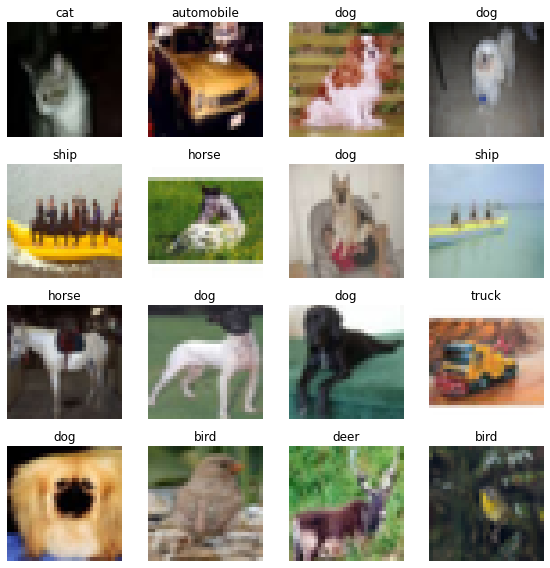

In [2]:
# Loading CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = get_CIFAR10(jkey(SEED), 0.25)

# Plotting samples
plot_samples(x_train, y_train, (4, 4))

***[RAPORT]*** One hot encoding zrealizowałem z uzyciem funkcji `jax.nn.one_hot()`. Sprawdzam poprawność dla 10 pierwszych etykiet:

In [3]:
y_train_one_hot = jax.nn.one_hot(y_train, 10)
jnp.concatenate((jnp.expand_dims(y_train[:10], axis=-1), y_train_one_hot[:10]), axis=1)

DeviceArray([[3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [7., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
             [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [5., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [4., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [8., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Minimalna architektura

***[RAPORT]*** Skorzystałem z modułu `flax.linen` (u mnie jako `nn`), co pozwoliło mi na wysokopoziomowe sekwencyjne zdefiniowanie
architektury modelu. Dzięki temu mam dostęp do takich warstw jak `nn.Conv()`, `nn.Dense()`, `nn.max_pool()` oraz funkcji aktywacji
`nn.sigmoid()`, `nn.softmax()`. Mój model `MinCNN` składa się z `2 * (5 * 3 * 3 * 3 + 5) + (4 * 4 * 5 * 10 + 10) = 1090` parametrów.
Specjalnie nie uyłem tutaj na koniec funkcji aktywacji `softmax`, poniewaz kozystam z wbudowanej funkcji kosztu,
`optax.softmax_cross_entropy`, która stosuje softmax na logitach przed wyliczeniem entropii.

```python
class MinCNN(nn.Module):
    
  @nn.compact
  def __call__(self, batch):
    
    batch_size = batch.shape[0]
    x = batch / 255
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.Conv(features=5, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.sigmoid(x)
    x = nn.max_pool(x, window_shape=(8, 8), strides=(8, 8))
    x = jnp.reshape(x, (batch_size, -1))
    x = nn.Dense(features=10)(x)
    # x = nn.softmax(x)
      
    return x
```

***[RAPORT]*** Prawdopodobieństwa poszczególnych klas zwracane przez niewytrenowany model dla pierwszych 5 przykładów:

In [4]:
def class_membership_hist(batch: Array):

    for sample in batch:
        plt.bar()

In [5]:
first_n = 8
dummy_batch = x_train[:first_n]
dummy_labels = y_train[:first_n]

init_state = create_MinCNN(dummy_batch, jkey(SEED))
dummy_predictions = predict_probs(init_state, dummy_batch)

print(f"Class probabilities for the first {first_n} images:")
print(dummy_predictions)

Class probabilities for the first 8 images:
[[0.07505817 0.20276655 0.03356202 0.10776416 0.10112245 0.05324936
  0.11353416 0.13643922 0.09820414 0.07829972]
 [0.07752115 0.20386973 0.03415636 0.10630428 0.10065502 0.05117786
  0.11359628 0.13491955 0.09986337 0.07793646]
 [0.07437844 0.20869084 0.03285408 0.10588016 0.09863321 0.05213904
  0.11555181 0.13361973 0.1000652  0.07818756]
 [0.07560377 0.20487252 0.03372012 0.10459484 0.09933451 0.05207061
  0.11487657 0.13551828 0.09916038 0.08024856]
 [0.07517201 0.2067138  0.03396319 0.10509751 0.10014293 0.05196266
  0.11346807 0.13611034 0.09886051 0.07850897]
 [0.07520315 0.20291497 0.03383315 0.10748243 0.10023594 0.05297302
  0.11548894 0.13412856 0.09875543 0.07898438]
 [0.07577918 0.20467648 0.03378669 0.10542026 0.10112271 0.05136016
  0.11374167 0.1350648  0.09857008 0.08047804]
 [0.07521521 0.20167308 0.0347601  0.10770062 0.09995402 0.05259723
  0.1162159  0.13401665 0.09917453 0.07869271]]


***[RAPORT]*** Przy treningu modelu inspirowałęm się [tutorialem flax](https://flax.readthedocs.io/en/latest/getting_started.html).
Skorzystałem z takich elementów jak `flax.training.train_state.TrainState()` który pozwala w łątwy sposób na funkcyjną implementację
treningu, co jest zgodne z filozofią *JAX*. Jako optymalizatora uzyłem `optax.sgd`. Trening zaimplementowałem w postaci 2 funkcji.
Funkcja `train_and_eval()` iteruje po epokach wywołując funkcję `train_epoch()`, zbiera dane metryki, zapisuje logi i checkpointy.
Z kolei funkcja `train_epoch()` to główna oś treningu i jej kod zamieszczam poniej:

```python
def train_epoch(
	state: TrainState,
	x_train: Array,
	y_train: Array,
	batch_size: int,
	perm_key: PRNGKey
) -> Tuple[TrainState, Scalar, Scalar]:

	n_samples = x_train.shape[0]
	steps_per_epoch = n_samples // batch_size

	perms = jax.random.permutation(perm_key, n_samples)[:steps_per_epoch * batch_size]
	perms = jnp.reshape(perms, (steps_per_epoch, batch_size))

	epoch_loss = []
	epoch_accuracy = []

	for perm in perms:

		x_batch = x_train[perm, ...]
		y_batch = y_train[perm, ...]
		grads, loss, accuracy = apply_model(state, x_batch, y_batch)
		state = update_model(state, grads)
		epoch_loss.append(loss)
		epoch_accuracy.append(accuracy)
	
	return state, np.mean(epoch_loss), np.mean(epoch_accuracy)
```

***[RAPORT]*** Model o minimalnej architekturze wytrenował się w `28m 55.3s`. Ponizej metryki ukazujące przebieg treningu:

![](checkpoints/min_cnn/metrices.png)

***[RAPORT]*** A tutaj prawdopodobieństwa przynalezności do klas dla pierwszych 5 przykładów:

In [6]:
final_state = restore_checkpoint("checkpoints/min_cnn", init_state)
min_cnn_predictions = predict_probs(final_state, x_train[:first_n])

print(f"Class probabilities for the first {first_n} images:")
print(min_cnn_predictions)

Class probabilities for the first 8 images:
[[1.6351845e-02 3.3094208e-03 2.7480134e-01 2.0301440e-01 2.0173578e-01
  1.6203035e-01 8.6134173e-02 3.7256226e-02 9.8659107e-03 5.5005490e-03]
 [8.0743199e-03 1.0824299e-03 1.2475841e-02 4.0876630e-01 4.2878814e-02
  3.6677137e-01 5.4587428e-02 9.9288218e-02 4.8124818e-03 1.2628244e-03]
 [4.4544441e-01 4.5102559e-02 1.7088498e-03 1.3858438e-04 7.4281660e-04
  9.4842115e-05 9.4488038e-05 3.3477758e-04 4.9171409e-01 1.4624525e-02]
 [7.2587575e-03 6.1495448e-03 2.2724165e-01 1.3849027e-02 8.2262084e-02
  4.0296618e-02 3.6129616e-02 5.8107072e-01 3.4496791e-04 5.3970399e-03]
 [5.4906908e-02 9.4900459e-02 4.8383188e-02 7.7111900e-02 3.0997600e-02
  7.5283028e-02 1.0188414e-01 1.2776242e-01 8.2319513e-02 3.0645081e-01]
 [6.0247120e-02 6.6573137e-01 2.6908983e-03 4.5418353e-03 5.3998624e-04
  2.2281616e-03 4.8180873e-04 1.8737118e-03 8.0615669e-02 1.8104942e-01]
 [1.0575492e-02 5.0813965e-03 4.6548855e-02 1.9966845e-01 1.5520985e-01
  1.4402881e-0

***[RAPORT]*** Model ze zwiększoną liczbą filtrów z 5 do 20 wytrenował się w `brak danych`. 
Po 150 epokach osiągneliśmy accuracy ok `60%` z tendencją wzrostową, czyli mozna by było kontynuować trening by uzyskać wyzszy wynik
bez overfitingu. liczba parametrów zwiększyła się 4-krotnie. Ponizej metryki ukazujące przebieg treningu:

![](checkpoints/min_cnn_plus/metrices.png)

***[RAPORT]*** Blok konwolucyjny z aktywacją relu:
```python
def conv_block(x: Array, features: int) -> Array:

    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

    return x
```
***[RAPORT]*** Zmodyfikowany model:
```python
class DoubleBlockCNN(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 20)
        x = conv_block(x, 40)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dense(features=10)(x)
        
        return x
```